ANTRACT Dataset :  Evaluation
===============================

This notebook serves as evaluation for the face recognition system.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets
from sklearn.metrics import precision_recall_fscore_support as score


from src import clusterize

In [2]:
model_names = { # for the discrepancies for the model names and the dataset ones
    'Gaulle, Charles de'           : 'Charles De Gaulle',
    'Auriol, Vincent'              : 'Vincent Auriol',
    'Pompidou, Georges'            : 'Georges Pompidou',
    'Bidault, Georges'             : 'Georges Bidault',
    'Eisenhower, Dwight David'     : 'Dwight Eisenhower',
    'Eisenhower, Dwight'           : 'Dwight Eisenhower',
    'Khrouchtchev, Nikita'         : 'Nikita Khrouchtchev',
    'Mollet, Guy'                  : 'Guy Mollet',
    'Adenauer, Konrad'             : 'Konrad Adenauer',
    'Molotov, Viatcheslav'         : 'Viatcheslav Molotov',
    'Mendès France, Pierre'        : 'Pierre Mendès France',
    "Elizabeth d'Angleterre"       : 'Elisabeth II',
    'Mitterrand, François'         : 'François Mitterrand',
    'Ben Bella, Ahmed'             : 'Ahmed Ben Bella',
    '0'                            : '0'
}

Load the original dataset

In [3]:
df_dataset = pd.read_csv('dataset_antract.csv')
df_dataset

,media,url,segment,start,end,person
0,http://www.ina.fr/media/AFE86003905,/Media/AF/AFE86003905.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,263.0,265.0,"Ben Bella, Ahmed"
1,http://www.ina.fr/media/AFE86003905,/Media/AF/AFE86003905.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,270.0,273.0,"Ben Bella, Ahmed"
2,http://www.ina.fr/media/AFE86003847,/Media/AF/AFE86003847.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,185.0,188.0,"Ben Bella, Ahmed"
3,http://www.ina.fr/media/AFE86003840,/Media/AF/AFE86003840.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,54.0,57.0,"Ben Bella, Ahmed"
4,http://www.ina.fr/media/AFE86003905,/Media/AF/AFE86003905.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,255.0,256.0,"Ben Bella, Ahmed"
...,...,...,...,...,...,...
211,http://www.ina.fr/media/AFE86004878,/Media/AF/AFE86004878.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86004...,506.0,509.0,0
212,http://www.ina.fr/media/AFE86004740,/Media/AF/AFE86004740.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86004...,109.0,112.0,0
213,http://www.ina.fr/media/AFE86004580,/Media/AF/AFE86004580.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86004...,194.0,196.0,0
214,http://www.ina.fr/media/AFE86004419,/Media/AF/AFE86004419.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86004...,677.0,678.0,0


In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON

ENDPOINT = "https://okapi.ina.fr/antract/api/saphir/sparql_search"
sparql = SPARQLWrapper(ENDPOINT)
sparql.setReturnFormat(JSON)

with open('queries/antract_year_by_media.rq', 'r') as f:
    query = f.read()

In [5]:
df_dataset['label'] = df_dataset['person'].apply(lambda x: model_names[str(x)])
def get_year(media):
    q = query.replace('?media', f"<{media}>")
    sparql.setQuery(q)
    results = sparql.query().convert()["results"]["bindings"]
    date = results[0]['date']['value']
    return int(date[0:4])

df_dataset["year"] = df_dataset["media"].apply(get_year)

In [6]:
len(df_dataset[df_dataset['person']=='0'])

39

In [7]:
len(df_dataset['media'].unique())

129

In [8]:
len(df_dataset['segment'].unique())

198

Load computation results (obtained using `bulk_run.py`)

In [9]:
with open('./intermediate/results_antract.json', 'r') as f:
    results = json.load(f)
len(results)

216

In [10]:
clusters = [clusterize.main(clusterize.from_dict(p), confidence_threshold=0.0, merge_cluster=True, min_length=0) for p in results]

In [11]:
l = len(df_dataset)
df_dataset['predicted'] = np.zeros(l)
df_dataset['confidence'] = np.zeros(l)
durations = []

for i, x in df_dataset.iterrows():
    cur = clusters[i]
    start = x['start']
    end = x['end']
    b = np.arange(start, end)
    durations.append(end-start)

    found = False
    for c in cur:
        a = np.arange(np.floor(c['start_npt']), np.ceil(c['end_npt']))

        if len(np.intersect1d(a,b)) > 0:
            df_dataset.loc[i, 'predicted'] = c['name']
            df_dataset.loc[i, 'confidence'] = float(c['confidence'])

            if x['label'] == c['name']:
                break

df_dataset['duration'] = durations
df_dataset

,media,url,segment,start,end,person,label,year,predicted,confidence,duration
0,http://www.ina.fr/media/AFE86003905,/Media/AF/AFE86003905.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,263.0,265.0,"Ben Bella, Ahmed",Ahmed Ben Bella,1963,Ahmed Ben Bella,0.868389,2.0
1,http://www.ina.fr/media/AFE86003905,/Media/AF/AFE86003905.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,270.0,273.0,"Ben Bella, Ahmed",Ahmed Ben Bella,1963,0.0,0.000000,3.0
2,http://www.ina.fr/media/AFE86003847,/Media/AF/AFE86003847.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,185.0,188.0,"Ben Bella, Ahmed",Ahmed Ben Bella,1962,Ahmed Ben Bella,0.837472,3.0
3,http://www.ina.fr/media/AFE86003840,/Media/AF/AFE86003840.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,54.0,57.0,"Ben Bella, Ahmed",Ahmed Ben Bella,1962,0.0,0.000000,3.0
4,http://www.ina.fr/media/AFE86003905,/Media/AF/AFE86003905.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86003...,255.0,256.0,"Ben Bella, Ahmed",Ahmed Ben Bella,1963,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
211,http://www.ina.fr/media/AFE86004878,/Media/AF/AFE86004878.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86004...,506.0,509.0,0,0,1953,0.0,0.000000,3.0
212,http://www.ina.fr/media/AFE86004740,/Media/AF/AFE86004740.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86004...,109.0,112.0,0,0,1951,0.0,0.000000,3.0
213,http://www.ina.fr/media/AFE86004580,/Media/AF/AFE86004580.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86004...,194.0,196.0,0,0,1948,0.0,0.000000,2.0
214,http://www.ina.fr/media/AFE86004419,/Media/AF/AFE86004419.mp4,http://www.campus-AAR.fr/sceneSegment_AFE86004...,677.0,678.0,0,0,1945,0.0,0.000000,1.0


In [12]:
len(df_dataset['segment'].unique())

198

In [13]:
df_dataset['duration'].describe()

count    216.000000
mean       4.321759
std        5.830907
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       53.000000
Name: duration, dtype: float64

<AxesSubplot:ylabel='Frequency'>

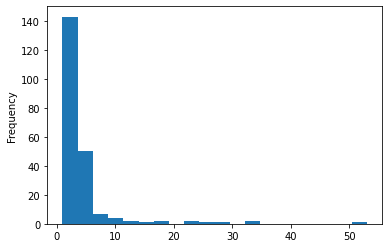

In [14]:
df_dataset['duration'].plot.hist(bins=20)

In [15]:
classes = [str(p) for p in df_dataset['label'].unique()]

def compute_metrics(threshold=0.5, year=None):
    dts = df_dataset
    if year is not None:
        dts = df_dataset[df_dataset['year'].between(year -5, year+5)]
        
    label = np.array([str(p) for p in dts['label']])
    predicted = np.array([str(p['predicted']) if p['confidence'] > threshold else '0' for i, p in dts.iterrows() ])
    
    return score(label, predicted, labels=classes, zero_division=1)

@widgets.interact(threshold=widgets.FloatSlider(min=0, max=1, step=0.05, value=0.60), 
                  year=widgets.fixed(None))
def show_metrics(threshold=0.5, year=None):
    precision, recall, fscore, support = compute_metrics(threshold, year)
    
    dfx = pd.DataFrame()
    dfx['index']= classes
    dfx['precision'] =  precision
    dfx['recall'] =  recall
    dfx['fscore'] =  fscore
    dfx['support'] =  support

    tot = {
        'index' : 'tot (excluded 0)',
        'precision': np.average(precision[0:-1], weights=support[0:-1]),
        'recall' : np.average(recall[0:-1], weights=support[0:-1]),
        'fscore' : np.average(fscore[0:-1], weights=support[0:-1]),
        'support' : np.sum(support)
    }
    dfx = dfx.append(pd.DataFrame(tot, index=[7]))
    return dfx

interactive(children=(FloatSlider(value=0.6, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

In [16]:
precision =[]
recall =[]
fscore =[]

_range = np.arange(0, 0.8, 0.05)
for threshold in _range:
    p, r, f, support = compute_metrics(threshold)
    precision.append(np.average(p[0:-1], weights=support[0:-1]))
    recall.append(np.average(r[0:-1], weights=support[0:-1]))
    fscore.append(np.average(f[0:-1], weights=support[0:-1]))

In [17]:
np.argmax(fscore) * 0.05

0.0

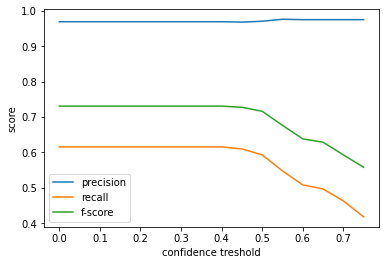

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(_range, precision, label='precision')  # Plot some data on the axes.
ax.plot(_range, recall, label='recall')  # Plot more data on the axes...
ax.plot(_range, fscore, label='f-score')  # ... and some more.
ax.set_xlabel('confidence treshold')  # Add an x-label to the axes.
ax.set_ylabel('score')  # Add a y-label to the axes.
ax.legend()  # Add a legend
plt.savefig('plot/antract_facerec_precision.pdf')  

0.5 looks like the best threshold

In [19]:
show_metrics(0.5)

,index,precision,recall,fscore,support
0,Ahmed Ben Bella,1.000000,0.461538,0.631579,13
1,François Mitterrand,1.000000,0.923077,0.960000,13
2,Pierre Mendès France,1.000000,0.615385,0.761905,13
3,Guy Mollet,0.923077,0.923077,0.923077,13
4,Georges Bidault,0.833333,0.714286,0.769231,14
5,Charles De Gaulle,1.000000,0.578947,0.733333,19
6,Nikita Khrouchtchev,1.000000,0.384615,0.555556,13
7,Vincent Auriol,1.000000,0.461538,0.631579,13
8,Konrad Adenauer,1.000000,0.538462,0.700000,13
9,Dwight Eisenhower,0.857143,0.461538,0.600000,13


In [20]:
with open('plot/latex_antract.txt', 'w') as f:
    show_metrics(0.5).to_latex(f, index=False)

In [21]:
def filter_by(prop):
    def filter_with(what):
        return df_dataset[df_dataset[prop] == what]
    return filter_with
    
widgets.interact(filter_by('label'), what=widgets.Dropdown(
    options=df_dataset['label'].unique(),
    description='Person:',
));

interactive(children=(Dropdown(description='Person:', options=('Ahmed Ben Bella', 'François Mitterrand', 'Pier…

In [22]:
df_dataset['year'].describe()

count     216.000000
mean     1956.976852
std         6.910351
min      1945.000000
25%      1951.750000
50%      1956.500000
75%      1963.000000
max      1968.000000
Name: year, dtype: float64

In [23]:
precision_year =[]
recall_year =[]
fscore_year =[]
support_year =[]

_range = np.arange(1945, 1970, 5)
for year in _range:
    p, r, f, support = compute_metrics(0.6, year)
    precision_year.append(np.average(p[0:-1], weights=support[0:-1]))
    recall_year.append(np.average(r[0:-1], weights=support[0:-1]))
    fscore_year.append(np.average(f[0:-1], weights=support[0:-1]))
    support_year.append(np.sum(f[0:-1]))

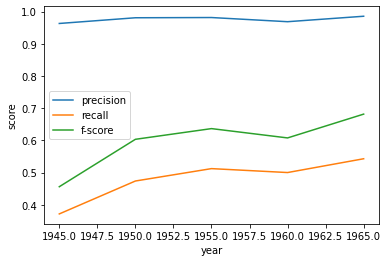

In [24]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(_range, precision_year, label='precision')  # Plot some data on the axes.
ax.plot(_range, recall_year, label='recall')  # Plot more data on the axes...
ax.plot(_range, fscore_year, label='f-score')  # ... and some more.

ax.set_xlabel('year')  # Add an x-label to the axes.
ax.set_ylabel('score')  # Add a y-label to the axes.
ax.legend()  # Add a legend
plt.savefig('plot/antract_facerec_precision_year.pdf')  

In [25]:
for x in df_dataset['label'].unique():
    d = filter_by('label')(x)
    print('- %s : %2.f' % (x, d["year"].mean()))

- Ahmed Ben Bella : 1962
- François Mitterrand : 1961
- Pierre Mendès France : 1958
- Guy Mollet : 1956
- Georges Bidault : 1950
- Charles De Gaulle : 1962
- Nikita Khrouchtchev : 1959
- Vincent Auriol : 1953
- Konrad Adenauer : 1959
- Dwight Eisenhower : 1953
- Elisabeth II : 1948
- Viatcheslav Molotov : 1951
- Georges Pompidou : 1965
- 0 : 1957


In [26]:
widgets.interact(filter_by('year'), what=widgets.Dropdown(
    options=sorted(df_dataset['year'].unique()),
    description='Year:',
));

interactive(children=(Dropdown(description='Year:', options=(1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1…

In [27]:
widgets.interact(filter_by('media'), what=widgets.Dropdown(
    options=sorted(df_dataset['media'].unique()),
    description='Media:',
));

interactive(children=(Dropdown(description='Media:', options=('http://www.ina.fr/media/AFE86003399', 'http://w…

In [28]:
clusterize.main(clusterize.from_dict(results[157]), confidence_threshold=0.0, dominant_ratio=0.0, weighted_dominant_ratio=0.0, merge_cluster=True, min_length=0)

[{'name': 'Viatcheslav Molotov',
  'project': 'antract',
  'track_id': 1491,
  'confidence': 0.26494732081855216,
  'locator': 'http://www.ina.fr/media/AFE86003480',
  'bounding': {'x': 364,
   'y': 105,
   'w': 95,
   'h': 118,
   'xywh': '364,105,95,118'},
  'rect': [364.0, 105.0, 459.0, 223.0],
  'frame_size': [384, 512],
  'end_sample': 4,
  'start_sample': 4,
  'end_frame': 8850,
  'start_frame': 8850,
  'end_npt': 354.0,
  'start_npt': 354.0,
  'merged_tracks': [1491]},
 {'name': 'Konrad Adenauer',
  'project': 'antract',
  'track_id': 1489,
  'confidence': 0.2687614426376399,
  'locator': 'http://www.ina.fr/media/AFE86003480',
  'bounding': {'x': 392,
   'y': 232,
   'w': 90,
   'h': 108,
   'xywh': '392,232,90,108'},
  'rect': [392.0, 232.0, 482.0, 340.0],
  'frame_size': [384, 512],
  'end_sample': 1,
  'start_sample': 1,
  'end_frame': 8775,
  'start_frame': 8775,
  'end_npt': 351.0,
  'start_npt': 351.0,
  'merged_tracks': [1489]},
 {'name': 'Georges Pompidou',
  'project': 

In [29]:
df_dataset['media'].value_counts()

http://www.ina.fr/media/AFE86004079    6
http://www.ina.fr/media/AFE86004588    5
http://www.ina.fr/media/AFE86004419    5
http://www.ina.fr/media/AFE86004018    4
http://www.ina.fr/media/AFE86003966    4
                                      ..
http://www.ina.fr/media/AFE86004865    1
http://www.ina.fr/media/AFE86003845    1
http://www.ina.fr/media/AFE86004433    1
http://www.ina.fr/media/AFE86004430    1
http://www.ina.fr/media/AFE86003691    1
Name: media, Length: 129, dtype: int64